In [ ]:
%%capture --no-stderr
%pip install -U --quiet langchain-community tiktoken langchain-openai langchainhub faiss-cpu langchain langgraph langchain-text-splitters 

In [ ]:
import io
import os

import numpy as np
import pandas as pd

import getpass

# teradata lib
from teradataml import *

# LLM
import sqlalchemy
from sqlalchemy import create_engine
from langchain import PromptTemplate, SQLDatabase, LLMChain
from langchain_community.utilities.sql_database import SQLDatabase
from langchain_community.agent_toolkits import create_sql_agent
from langchain_openai import ChatOpenAI
from langchain_core.messages import AIMessage
from langchain_core.prompts.chat import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
    MessagesPlaceholder,
)
from langchain_core.tools import tool
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import FAISS
from datetime import datetime

# VectorStore
from teradatagenai import VSManager, VectorStore
from teradataml import create_context, set_auth_token

configure.byom_install_location = "mldb"
configure.val_install_location = "val"

# Suppress warnings
warnings.filterwarnings("ignore")
display.max_rows = 5

In [ ]:
%run -i ../startup.ipynb
eng = create_context(host = 'host.docker.internal', username='demo_user', password = password)
print(eng)

### VectorStore context

In [4]:
context = create_context(
    host=getpass.getpass("host"), username=getpass.getpass("user_name"), password=getpass.getpass("password")
)

In [5]:
base_url = "https://xxxx.xxxx"
set_auth_token(
    base_url=base_url,
    pat_token="pzxxxx",
    pem_file="key.pem",
)

True

In [6]:
from langchain_core.tools import tool
from datetime import datetime

In [7]:
# model name
# define constants
model_name = "meta/llama-3.1-8b-instruct"
base_url = "http://xx.xx.xx.xx:0000/v1"
api_key = "$API_KEY_REQUIRED_IF_EXECUTING_OUTSIDE_NGC"

# define LLM
llm = ChatOpenAI(
    model=model_name,
    temperature=0.2,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    base_url=base_url,
    api_key="$API_KEY_REQUIRED_IF_EXECUTING_OUTSIDE_NGC",
)

------------------------------------

### Utilities

In [51]:
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda
from IPython.display import display, Markdown
from langgraph.prebuilt import ToolNode


def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }


def logs_console(msg: str):
    """Print formatted log message."""
    print(f"\nℹ️ LOGS : {msg}")
    print("=" * 50)
    # add_log(f"\nℹ️ LOGS : {msg}")
    # chatbot_ui.chat_logs.append(f"\nℹ️ LOGS : {msg}")


def thought(thought: str):
    """Record agent's thinking process."""
    print(f"\n🤔 Thought: {thought}")


def action_obs(action: str, result: any, mrkdwn: str = ""):
    """Record agent's actions and results."""
    print(f"🎯 Action: {action}")
    if mrkdwn:
        display(Markdown(mrkdwn))
    print(f"📝 Observation: {result}")
    print("=" * 50)

# Define the Agent State

In [9]:
from typing import Annotated

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig
from typing_extensions import TypedDict, Dict, List, Annotated, Any, Union, Optional

# from typing import Dict, List, Annotated, Any, Union
from langgraph.graph.message import AnyMessage, add_messages


class AgentState(TypedDict, total=False):
    messages: Optional[Annotated[list[AnyMessage], add_messages]] = []
    # messages: List[Union[HumanMessage, AIMessage, SystemMessage]]
    user_query: Optional[str] = ""
    lookup_response: Optional[str] = ""
    user_info: Optional[str] = ""
    proposal: Optional[str] = ""
    next_agent: Optional[str] = ""
    propensity: Optional[float] = 0.0
    current_node: Optional[str] = ""
    is_coverage: Optional[bool] = False

### Load the pdf to VectorStore

In [10]:
VSManager.health()

Database connection established in 1043.02 milliseconds.


,status,platform,version,sessions_count
0,up,nim,1.0.262,152


In [11]:
# create vector store
vs_ti = VectorStore("TravelInsurance3")

Database connection established in 617.17 milliseconds.
Vector store TravelInsurance3 is initialized for the session.


-------------------------------------------

#### Upload the pdf document

In [12]:
# files = [os.path.join(os.getcwd(), "SmartTraveller_International.pdf")]
# files

In [ ]:
# vs_ti.create(
#     embeddings_model="nvidia/nv-embedqa-mistral-7b-v2",
#     chat_completion_model="meta/llama-3.1-8b-instruct",
#     search_algorithm="VECTORDISTANCE",
#     top_k=10,
#     database_name="oaf",
#     object_names="tbl_TravelInsurance",
#     data_columns=["chunks"],
#     vector_column="VectorIndex",
#     chunk_size=100,
#     optimized_chunking=False,
#     document_files=files,
# )

In [13]:
@tool
def lookup_policy(query: str) -> str:
    """Consult the company insurance policies to check policy wordings and coverage."""
    docs = vs_ti.similarity_search(question=query)
    return docs

-------------------------------------------------

### Agent 2: User Insurance policy Details

In [14]:
from datetime import datetime
from langchain_core.runnables import RunnableConfig


def fetch_user_insurance_information(state: AgentState) -> AgentState:
    """Fetch all the insurance policies for the user along with corresponding personal information and policy information.

    Returns:
        A dictionary which contains the user's personal and policy details, Claim details, etc. to the user.
    """
    logs_console("fetch_user_insurance_information called")

    customer_id = "C1001"
    qry = "select * from customer360  WHERE CustomerID = ? "

    # with eng.raw_connection() as connection:
    conn = eng.raw_connection()
    cursor = conn.cursor()
    rows = cursor.execute(qry, (customer_id,)).fetchall()
    column_names = [column[0] for column in cursor.description]
    results = [dict(zip(column_names, row)) for row in rows]
    cursor.close()
    conn.close()
    action_obs("fetch_user_insurance_information", results[0])
    state["user_info"] = results[0]
    state["current_node"] = "fetch_user_insurance_information"
    state["next_agent"] = "respond_and_continue"
    state["is_coverage"] = True
    logs_console(f"state at user-info: {state}")
    logs_console("fetch_user_insurance_information completed...")
    return state

-----------------------------------------------------------------------

### Agent 3: Predict the user's Propensity to buy Dental treatment

In [15]:
def fetch_user_propensity(state: AgentState) -> AgentState:
    """Fetch propensity to buy a dental treatment based on customer's personal information and previous health and dental related information.
    Returns:
        A dictionary which contains the customer's Customer ID and prediction.
    """
    logs_console("fetch_user_propensity called")
    thought(
        "I have to pass customer's details to ClearScape Analytics hosted Model to get the propensity of buying the Dental Treatment"
    )

    try:
        qry = """
        SELECT * FROM "mldb".PMMLPredict(
            ON "df_test" AS InputTable
            PARTITION BY ANY 
            ON (select model_id,model from "DEMO_USER"."mm_glm") AS ModelTable
            DIMENSION
            USING
            Accumulate('Customer_ID')
            OverwriteCachedModel('*')
        ) as sqlmr
        """

        conn = eng.raw_connection()
        cursor = conn.cursor()
        rows = cursor.execute(qry).fetchall()
        column_names = [column[0] for column in cursor.description]
        results = [dict(zip(column_names, row)) for row in rows]
        cursor.close()
        conn.close()
        action_obs("fetch_user_propensity", results[0]["prediction"])
        # state["messages"].append(AIMessage(content=float(results[0]['prediction'])))
        state["propensity"] = float(results[0]["prediction"])
        state["current_node"] = "fetch_user_propensity"
        state["next_agent"] = "assistant"
        logs_console(f"state at propensity: {state}")
        logs_console("fetch_user_propensity completed returning propensity...")

        return state
    except Exception as e:
        print(f"Error in fetch_user_propensity: {e}")
        return {"error": e}

-----------------------------------------------------------

### Agent 4: Generate the Insurance Proposal

In [16]:
def generate_insurance_proposal(state: AgentState) -> AgentState:
    """Fetch all the insurance policies for the user along with corresponding personal information and policy information.
    Returns:
        Generate a Dental Treatment Proposal for given user.
    """
    logs_console("generate_insurance_proposal called")

    thought(
        "I have create a proposal for the Dental Treatment as addon to existing Insurance"
    )

    customer_id = "C1001"

    qry = "select * from customer360  WHERE CustomerID = ? "

    # with eng.raw_connection() as connection:
    conn = eng.raw_connection()
    cursor = conn.cursor()
    rows = cursor.execute(qry, (customer_id,)).fetchall()
    column_names = [column[0] for column in cursor.description]
    results = [dict(zip(column_names, row)) for row in rows]
    cursor.close()
    conn.close()

    action_obs("generate_insurance_proposal - Get user details", results[0])

    # setup LLM
    logs_console("Now, generating the Proposal")
    primary_assistant_prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful customer support assistant for ABC Overseas Travel Insurance. "
                "Use the provided customer information and write a dental treatment proposal, as addon to existing insurance policies,"
                "Write a travel insurance proposal for Dental Treatment as addon using given features. Write it with proper markdown and style."
                "Add the reasoning for Propensity to buy Dental Treatment basis on propensity and user_info provided below:\n\n"
                "Example: Bases on customer's age, location, and previous dental history, we have calculated the propensity to buy Dental Treatment as 0.8."
                "\n\nCurrent user:\n<User>\n{user_info}\n</User>"
                "\n\nPropensity to buy Dental Treatment: {propensity}"
                "\nCurrent time: {time}.",
            ),
            ("placeholder", "{messages}"),
        ]
    ).partial(time=datetime.now)

    prompt1 = primary_assistant_prompt.format_messages(
        user_info=results[0], propensity=state["propensity"]
    )
    response = llm.invoke(prompt1)
    action_obs(
        "generate_insurance_proposal - generate the proposal",
        None,
        response.content,
    )
    state["proposal"] = response.content
    state["next_agent"] = "end"
    logs_console(f"state at proposal{state}")
    logs_console("generate_insurance_proposal completed")
    return state

------------------------------------

### Agent 5 Intent identification

In [36]:
from typing import Annotated, Literal, Sequence, TypedDict
from langchain_core.output_parsers import JsonOutputParser
import os
from typing import Dict, List, Literal, Optional, Any
from langgraph.graph import END, StateGraph, START
from enum import Enum
from pydantic import BaseModel, Field


def insurance_identify_intent(state) -> Literal["retrieve", "agent"]:
    """
    Determines whether the user is asking for insurance policy or claim related question

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the intent is related to policy or not
    """

    logs_console("insurance_identify_intent calls")

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        insurance_binary_score: str = Field(description="intent score 'yes' or 'no'")

    # LLM with tool and validation
    llm_with_tool = llm.with_structured_output(grade, method="function_calling")

    # Prompt
    prompt = PromptTemplate(
        template="""You are a specialized travel insurance intent recognition system.
        Analyze the following user query and identify the most relevant travel insurance intent.
        
        Here is the user question: {question} \n
        
        Available intents:
        - policy_information: Questions about policy terms, documentation, or general policy details
        - claim_process: Questions about filing claims, claim status, or claim requirements
        - coverage_details: Questions about what is covered or not covered by travel insurance, coverage period, etc.
        - eligibility: Questions about who can purchase or qualify for travel insurance
        - pricing: Questions about costs, premiums, or payment options, refunds, etc.
        - medical_coverage: Questions about medical coverage, medical expenses, etc.
        - trip_cancellation: Questions about trip cancellation, refunds, etc.
        - documentation: Questions about required documents, proof of purchase, etc.
        - emergency_assistance: Questions about emergency services, medical evacuation, etc.
        - cancellation_policy: Questions about trip cancellation, refunds, etc.
        - trip delay: Questions about trip delays, missed connections, etc.
        - personal liability: Questions about personal liability coverage, legal expenses, etc.
        - multiple injuries: Questions about coverage for multiple injuries, accidents, etc.
        - dental_treatment: Questions about dental treatment coverage, dental emergencies, etc.
        - general_inquiry: General questions about travel insurance not fitting other categories
        - customer_service: Questions about contacting customer service, support options, email address, phone numbers, etc.
        - other: Queries not related to travel insurance
        
        Give a binary score 'yes' or 'no' score to indicate whether the question is relevant to travel insurance or not.""",
        input_variables=["question"],
    )

    # Chain
    chain = prompt | llm_with_tool

    question = state["messages"][-1].content
    logs_console(f"question : {question}")

    scored_result = chain.invoke({"question": question})

    logs_console(f"insurance intent scored_result: {scored_result}")

    score = scored_result.insurance_binary_score

    if score == "yes":
        print("---DECISION: intent found to insurance ---")
        return "retrieve"

    else:
        print("---DECISION: intent not found to insurance ---")
        print(score)
        return "agent"

------------------------------------

### Agent 6 Coverage Intent identification

In [37]:
def identify_coverage_intent(
    state: AgentState,
) -> Literal["fetch_user_info", "stop_end"]:
    """
    Determines whether the user is asking for insurance coverage or claim related question
    Args:
        state (messages): The current state
    Returns:
        str: A decision for whether the intent is related to coverage or not
    """

    logs_console("identify_coverage_intent calls")

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        coverage_binary_score: str = Field(
            description="coverage intent score 'yes' or 'no'"
        )

    # LLM with tool and validation

    llm_with_tool = llm.with_structured_output(grade, method="function_calling")

    # Prompt

    prompt = PromptTemplate(
        template="""You are a specialized travel insurance coverage intent recognition system.
        Analyze the following user query and identify the most relevant travel insurance intent.
        Here is the user question: {question} \n
        Available intents:
        - coverage_details: Questions about what is covered or not covered by travel insurance. 
            For example: 
            - What types of coverage does the policy provide?
            - Are medical expenses covered during a trip?
            - What exclusions apply to medical expenses coverage?
            - How does coverage differ between domestic and international travel?
            - Is coverage available for loss of personal belongings?
            - Are there any age limits for coverage?
            - What types of injuries are covered?
        Give a binary score 'yes' or 'no' score to indicate whether the question is related to insurance coverage or not.""",
        input_variables=["question"],
    )

    # Chain
    chain = prompt | llm_with_tool
    question = state["messages"][-1].content
    logs_console(f"question : {question}")
    scored_result = chain.invoke({"question": question})
    logs_console(f"coverage intent scored_result: {scored_result}")
    score = scored_result.coverage_binary_score
    if score == "yes":
        print("---DECISION: intent found to coverage ---")
        return "fetch_user_info"
    else:
        print("---DECISION: intent not found to coverage ---")
        print(score)
        return "stop_end"

In [ ]:
import json

def retrieve_insurance_policy(state: AgentState) -> any:
    """Retrieve the insurance policy based on the user query and provide the policy information."""
    logs_console("retrieve_insurance_policy called")
    assistant_prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                """You are a helpful customer support assistant for ABC Overseas Travel Insurance.
                    Use the following pieces of retrieved context to answer the question.
                    Briefly explain, provide a syntax in professional tone.
                    If you don't know the answer, just say that you don't know. 
                    Use the provided context to generate the response for the user's queries.

                    *Most Critical* : At the end of the response, give suggestion the user for addon treatment like, Dental treatment. 
                    For example, here is the response: <answer>, 'However, it does not include dental treatment, 
                    Based on your loyalty, and your contract, we would recommend extended warranty package which includes dental insurance.'

                    combine answer and suggestion in one sentence.
                    query: {query}
                    context: {context}

                    Response must be in JSON format:
                    answer: <answer>. <suggestion>
                    source: file name

                    Instructions:
                    - Give the answer in a professional tone and brief.
                """,
            ),
            ("placeholder", "{messages}"),
        ]
    )

    query = state["messages"][-1].content
    logs_console(f"query: {query}")
    docs = lookup_policy(query)
    context1 = (
        " ".join([i[0] for i in docs.similar_objects[["chunks"]][:5].values])
        + "\n file_name: "
        + docs.similar_objects[["TD_FILENAME"]].values[0][0]
    )
    prompt = assistant_prompt.format_messages(query=query, context=context1)
    response = llm.invoke(prompt)
    response_dict = json.loads(response.content)
    sources = response_dict["source"]
    logs_console(f"response: {response_dict}")
    state["lookup_response"] = response_dict["answer"]
    state["current_node"] = "retrieve_insurance_policy"
    state["next_agent"] = "fetch_user_info"
    state["user_info"] = ""
    state["proposal"] = ""
    state["propensity"] = 0.0

    logs_console(f"lookup resp: {response}")
    logs_console(f"generate state: {state}")
    logs_console("generate completed...")
    return state

-------------------

### part-1 : lookup and retrieve

In [39]:
### Nodes
def agent(state: AgentState) -> dict:
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    logs_console("MAIN agent called...")
    messages = state["messages"]
    response = llm.invoke(messages)
    return {"messages": [response]}

In [40]:
def welcome(state: AgentState):
    logs_console("welcome called")
    return state

-----------------------


# Agent Graph 

In [41]:
def prop_condition(state: AgentState) -> Literal["assistant", "stop_end"]:
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    try:
        logs_console("prop_condition called")

        prop = state["propensity"]
        logs_console(f"propensity : {prop}")
        state["current_node"] = "prop_condition"

        if float(prop) > 0.70:
            logs_console("propensity > 0.70")
            state["next_agent"] = "assistant"
            logs_console("setting up next agent = assistant")
            return "assistant"
        else:
            logs_console("propensity < 0.70")
            state["next_agent"] = "stop_end"
            logs_console("setting up next agent = stop_end")
            return "stop_end"
    except Exception as e:
        print(f"Error in prop_condition: {e}")
        return {"error": e}

In [42]:
def prop_condition_checker(state: AgentState):
    logs_console("prop_condition_checker called")
    logs_console(f"prop_condition_checker state: {state}")
    return state

In [43]:
def stop_end(state: AgentState):
    logs_console("stop_end called")
    logs_console(f"stop_end state: {state}")
    return state

In [44]:
def coverage_intent_checker(state: AgentState):
    logs_console("coverage_intent_checker called")
    return state

In [45]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, END, StateGraph

# -----------------------------
workflow1 = StateGraph(AgentState)

# Define a new graph

# Define the nodes we will cycle between
workflow1.add_node("agent", agent)  # agent
workflow1.add_node("welcome", welcome)  # agent
workflow1.add_node("retrieve", retrieve_insurance_policy)  # retrieval
workflow1.add_node("fetch_user_info", fetch_user_insurance_information)
workflow1.add_node("coverage_intent_checker", coverage_intent_checker)
workflow1.add_node("fetch_user_propensity", fetch_user_propensity)
workflow1.add_node("prop_condition_checker", prop_condition_checker)

workflow1.add_node("assistant", generate_insurance_proposal)
workflow1.add_node("stop_end", stop_end)

# EDGES
workflow1.add_edge(START, "welcome")
workflow1.add_conditional_edges(
    "welcome",
    # Assess agent decision
    insurance_identify_intent,
)

# workflow1.add_edge("fetch_user_insurance_information", END)
workflow1.add_edge("agent", END)
workflow1.add_edge("retrieve", "coverage_intent_checker")
workflow1.add_conditional_edges(
    "coverage_intent_checker",
    # Assess agent decision
    identify_coverage_intent,
)
workflow1.add_edge("fetch_user_info", "fetch_user_propensity")
# workflow.add_edge("fetch_user_propensity", "assistant")
workflow1.add_edge("fetch_user_propensity", "prop_condition_checker")
workflow1.add_conditional_edges(
    "prop_condition_checker",
    # Assess agent decision
    prop_condition,
)
workflow1.add_edge("assistant", END)
workflow1.add_edge("stop_end", END)


# add memory
memory = MemorySaver()

# Compile
app1 = workflow1.compile(
    checkpointer=memory, interrupt_before=["fetch_user_propensity"]
)

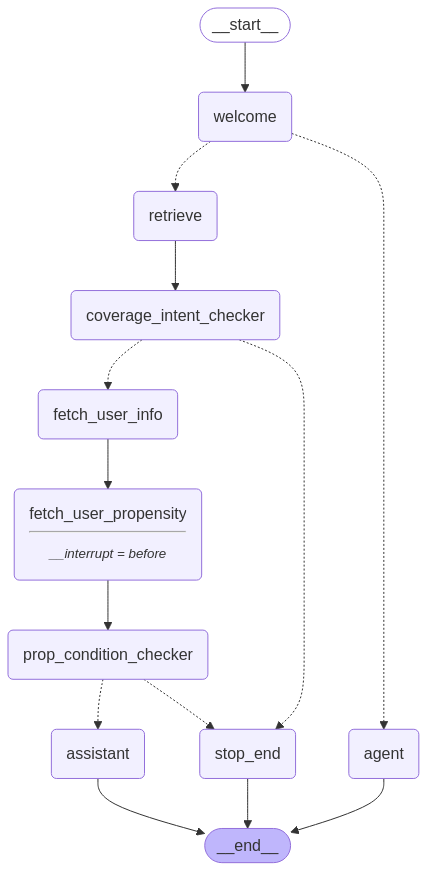

In [46]:
from IPython.display import Image, display

try:
    display(Image(app1.get_graph(xray=True).draw_mermaid_png()))
except Exception as e:
    print("ERROR: ", e)
    # This requires some extra dependencies and is optional
    pass

In [ ]:
import uuid
from langchain_core.messages import HumanMessage

# Update with the backup file so we can restart from the original place in each section
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # The passenger_id is used in our flight tools to
        # fetch the user's flight information
        "customer_id": "C1001",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}

# Function to run the workflow
def process_user_message(
    user_message: str, state=None, start_node: str = "welcome"
) -> dict[str, Any]:
    try:
        if state is None:
            state = AgentState(
                messages=[HumanMessage(content=user_message)],
                current_node=start_node,
                user_query="",
                lookup_response="",
                user_info="",
                proposal="",
                next_agent="",
                propensity=0.0,
                is_coverage=False,
            )


        # ================================================
        if start_node != "welcome":
            logs_console("workflow 2 started...")
            # ---------------------
            workflow2 = StateGraph(AgentState)
            workflow2.add_node("fetch_user_propensity", fetch_user_propensity)
            workflow2.add_node("assistant", generate_insurance_proposal)
            workflow2.add_node("prop_condition_checker", prop_condition_checker)
            workflow2.add_node("stop_end", stop_end)


            workflow2.add_edge(START, start_node)
            workflow2.add_edge("fetch_user_propensity", "prop_condition_checker")
            workflow2.add_conditional_edges(
                "prop_condition_checker",
                # Assess agent decision
                prop_condition,
            )

            workflow2.add_edge("assistant", END)
            workflow2.add_edge("stop_end", END)


            # add memory
            memory = MemorySaver()

            # Compile
            app2 = workflow2.compile(checkpointer=memory)
            logs_console("workflow 2 graph created...")

            try:
                display(Image(app2.get_graph(xray=True).draw_mermaid_png()))
            except Exception as e:
                print("\n\nERROR: ", e)
                # This requires some extra dependencies and is optional
                pass


            # Run the workflow
            result2 = app2.invoke(state, config=config, debug=False)
            return result2, state
        # ==================================================


        logs_console("workflow 1 started...")
        result1 = app1.invoke(state, config=config, debug=False)
        # Return result to the user
        return result1, state


    except Exception as e:
        print(f"Error in process_user_message: {e}")
        return {"error": e}, state

Insurance Assistant: Hello! I'm your insurance assistant. How can I help you today?
(Type 'q' or 'quit' to end the conversation)
---DECISION: intent found to insurance ---
---DECISION: intent found to coverage ---
🎯 Action: fetch_user_insurance_information
📝 Observation: {'CustomerID': 'C1001', 'Name': 'Jason Bourne', 'Age': 53, 'Income': 69116, 'Occupation': 'Nurse', 'MaritalStatus': 'Divorced', 'Children': 0, 'Location': 'Suburban', 'PolicyID': 'P1A', 'PolicyType': 'Travel', 'CoverageAmount': 507042, 'PremiumAmount': 3132, 'RenewalDate': '1/21/2025', 'ClaimID': 'C1A', 'ClaimType': 'Natural Disaster', 'ClaimAmount': 27612, 'ClaimStatus': 'Approved', 'InteractionID': 'I1A', 'InteractionType': 'Call', 'InteractionDate': '11/13/2024', 'InteractionNotes': 'Interaction notes for customer 1', 'Preferences': 'Budget-Friendly', 'BehavioralPatterns': 'Customer 1 prefers online transactions.', 'RiskLevel': 'High', 'RiskFactors': 'Customer 1 has a moderate risk profile due to driving history.', 

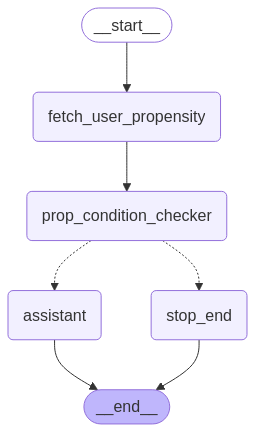


🤔 Thought: I have to pass customer's details to ClearScape Analytics hosted Model to get the propensity of buying the Dental Treatment
🎯 Action: fetch_user_propensity
📝 Observation: 0.8314349857708485

🤔 Thought: I have create a proposal for the Dental Treatment as addon to existing Insurance
🎯 Action: generate_insurance_proposal - Get user details
📝 Observation: {'CustomerID': 'C1001', 'Name': 'Jason Bourne', 'Age': 53, 'Income': 69116, 'Occupation': 'Nurse', 'MaritalStatus': 'Divorced', 'Children': 0, 'Location': 'Suburban', 'PolicyID': 'P1A', 'PolicyType': 'Travel', 'CoverageAmount': 507042, 'PremiumAmount': 3132, 'RenewalDate': '1/21/2025', 'ClaimID': 'C1A', 'ClaimType': 'Natural Disaster', 'ClaimAmount': 27612, 'ClaimStatus': 'Approved', 'InteractionID': 'I1A', 'InteractionType': 'Call', 'InteractionDate': '11/13/2024', 'InteractionNotes': 'Interaction notes for customer 1', 'Preferences': 'Budget-Friendly', 'BehavioralPatterns': 'Customer 1 prefers online transactions.', 'RiskLe

**Dental Treatment Proposal for Jason Bourne (CustomerID: C1001)**

**Proposal Details**

* **Customer Name:** Jason Bourne
* **Customer ID:** C1001
* **Policy ID:** P1A
* **Policy Type:** Travel
* **Current Coverage Amount:** $507,042
* **Current Premium Amount:** $3,132
* **Renewal Date:** 2025-01-21
* **Current Claim Status:** Approved (Natural Disaster)
* **Current Claim Amount:** $27,612

**Dental Treatment Proposal**

Based on our analysis of Jason Bourne's customer information and propensity to buy Dental Treatment, we are pleased to offer the following proposal:

**Dental Treatment Coverage**

* **Coverage Amount:** $50,000
* **Premium Amount:** $250 per year (add-on to existing policy)
* **Policy Term:** 1 year
* **Effective Date:** 2025-03-13

**Reasoning for Propensity to Buy Dental Treatment**

Bases on customer's age (53), location (Suburban), and previous dental history (not provided), we have calculated the propensity to buy Dental Treatment as 0.8314349857708485. This indicates a moderate to high likelihood of Jason Bourne purchasing Dental Treatment coverage.

**Key Factors Influencing Propensity**

* **Age:** As Jason Bourne approaches 60, he may be more likely to require dental treatment, increasing his propensity to buy Dental Treatment coverage.
* **Location:** Suburban locations often have access to better dental care, which may increase the likelihood of Jason Bourne purchasing Dental Treatment coverage.
* **Previous Dental History:** Although not provided, we assume that Jason Bourne may have had previous dental issues, increasing his propensity to buy Dental Treatment coverage.

**Benefits of Dental Treatment Coverage**

* **Comprehensive coverage for dental expenses**
* **Access to a network of dental providers worldwide**
* **Flexible payment options to suit your needs**
* **Add-on to existing policy, no need to purchase a separate policy**

**Next Steps**

We recommend that Jason Bourne carefully reviews the proposal and considers adding Dental Treatment coverage to his existing policy. If he has any questions or concerns, please do not hesitate to contact us.

**Proposal Expiration**

This proposal will expire on 2025-03-20. If Jason Bourne wishes to accept the proposal, please sign and return the attached acceptance form to us by the expiration date.

**Acceptance Form**

To accept this proposal, please sign and return the attached acceptance form to us by 2025-03-20.

---

Acceptance Form:

I, Jason Bourne, accept the Dental Treatment proposal as outlined above. I understand that this coverage will be added to my existing policy (P1A) and will be effective from 2025-03-13.

Signature: ______________________________
Date: __________________________________

Please return the signed acceptance form to us by 2025-03-20 to confirm your acceptance of this proposal.

📝 Observation: None
Dental proposal generated...
----------------------------------------------------
ALL DONE
----------------------------------------------------

Insurance Assistant: Thank you for chatting with me. Have a great day!


In [53]:
# Interactive chat loop
if __name__ == "__main__":
    print(
        "Insurance Assistant: Hello! I'm your insurance assistant. How can I help you today?"
    )
    print("(Type 'q' or 'quit' to end the conversation)")

    try:
        # Example
        # I am traveling to Malaysia, Does my insurance cover medical expense?
        # state = None
        while True:
            user_input = input("\nYou: ")

            if user_input.lower() in {"q", "quit"}:
                print(
                    "\nInsurance Assistant: Thank you for chatting with me. Have a great day!"
                )
                break

            # Process message
            result1, state = process_user_message(user_input)

            # Get the response
            if result1.get("lookup_response"):
                lookup_response1 = result1["lookup_response"]
                print(f"\n\nInsurance Assistant: {lookup_response1} \n\n")
                response_preview1 = lookup_response1
                # Update history with the response

                if result1.get("is_coverage"):
                    # Update state for next iteration
                    state["next_agent"] = "assistant"

                    # Test resuming from fetch_user_propensity
                    result2 = process_user_message(
                        user_input, start_node="fetch_user_propensity", state=state
                    )

                    response_preview2 = result2[0].get("proposal")
                    print("Dental proposal generated...")

                    print("----------------------------------------------------")
                    print("ALL DONE")
                    print("----------------------------------------------------")
            else:
                print("--- ELSE----")
                print(result1)
                response_preview = result1["messages"][-1].content
                print(f"\n**Insurance Assistant**: {response_preview}")

    except Exception as e:
        print(f"Error in main: {e}")

-------------------------

### END

-------------------------------------------